# Pearson Correlation against model loss

## Init

In [1]:
import os

path = os.getcwd()
# set the working directory
os.chdir('c:\Github\\new-peak-project\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Loading data

In [4]:
import pickle 

sensitivity_folder_name = 'cp_model_sensitivity_5node'
combined_folder_name = 'combined_systems_perturbation'
random_seeds = [4,5,6]
feature_random_seed = 50 

# generate experiment id 
exp_ids = []
exp_ids_sensitivity = []
metric_dfs = []
Cp_final_states_all = []
specie_ranges_all = []

for seed in random_seeds:
    experiment_id = combined_folder_name + '_' + str(seed) + '_' + str(feature_random_seed)
    exp_ids.append(experiment_id)
    # load the data
    experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
    metric_df = pd.read_pickle(experiment_folder+'metric_df.pkl')
    metric_dfs.append(metric_df)
    
    exp_id_sens = sensitivity_folder_name + '_' + str(seed) + '_' + str(feature_random_seed)
    exp_ids_sensitivity.append(exp_id_sens)
    # load Cp final states
    experiment_folder_sens = config['DATA_PATH'] + '/' + exp_id_sens + '/'
    Cp_final_states = pd.read_pickle(experiment_folder_sens+'Cp_final_states_sensitivity.pkl')
    Cp_final_states_all.append(Cp_final_states)
    # load specie ranges
    specie_ranges = pd.read_pickle(experiment_folder_sens+'specie_range.pkl')
    specie_ranges_all.append(specie_ranges)

In [5]:
metric_df1 = metric_dfs[0]

In [ ]:
# for each metric df, calculate the mean of the pearson correlation for all rows where the column 'Feature Data' is 'Mock Omics Data (A+B)' and 'Model' is 'Linear Regression'

omics_mean_pearson = []
for metric_df in metric_dfs:
    # filter the dataframe for the rows where the column 'Feature Data' is 'Mock Omics Data (A+B)'
    filtered_df = metric_df[metric_df['Feature Data'] == 'Mock Omics Data (A+B)']
    # filter the dataframe for the rows where the column 'Model' is 'Linear Regression'
    filtered_df = filtered_df[filtered_df['Model'] == 'Linear Regression']
    # calculate the mean of the pearson correlation for all rows
    omics_mean_pearson.append(filtered_df['Pearson Correlation'].mean())
    
# print to test the result 
print(omics_mean_pearson)

[0.8073877288364704, 0.7120018359296437, 0.8117295085853765]


(80,)


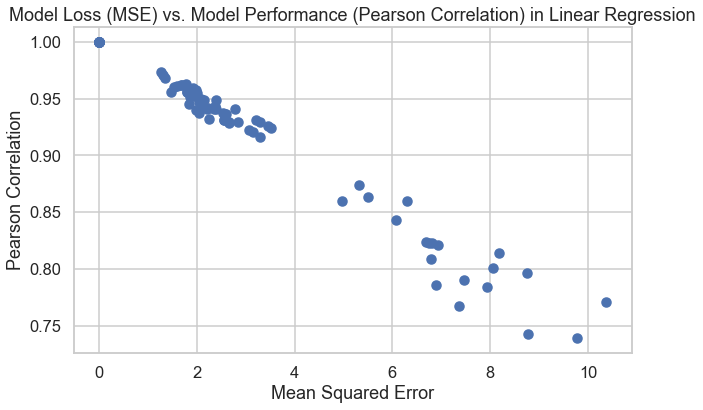

In [19]:
# extract the mean squared error for the linear regression model in metric_df1

mse = metric_df1[metric_df1['Model'] == 'Linear Regression']['Mean Squared Error']
# extract pearson correlation for the linear regression model in metric_df1 

pearson = metric_df1[metric_df1['Model'] == 'Linear Regression']['Pearson Correlation']
print(pearson.shape)
# correlation between the mean squared error and the pearson correlation using matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_palette("deep")
plt.figure(figsize=(10, 6))

plt.scatter(mse, pearson)
plt.xlabel('Mean Squared Error')
plt.ylabel('Pearson Correlation')   
plt.title('Model Loss (MSE) vs. Model Performance (Pearson Correlation) in Linear Regression')
plt.show()

(80,)


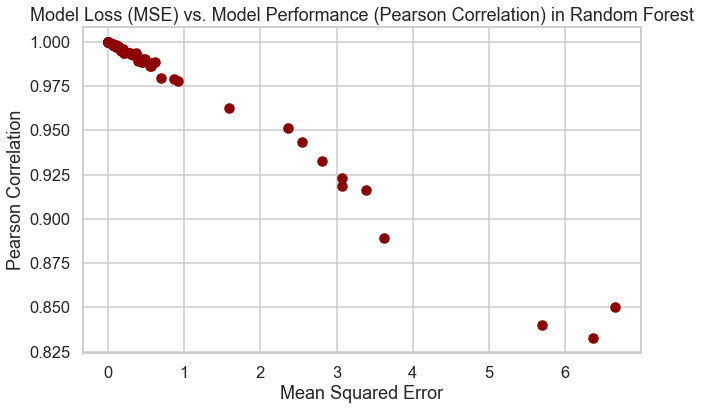

In [21]:
# extract the mean squared error for the linear regression model in metric_df1

mse = metric_df1[metric_df1['Model'] == 'Random Forest']['Mean Squared Error']
# extract pearson correlation for the linear regression model in metric_df1 

pearson = metric_df1[metric_df1['Model'] == 'Random Forest']['Pearson Correlation']
print(pearson.shape)
# correlation between the mean squared error and the pearson correlation using matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_palette("deep")
plt.figure(figsize=(10, 6))

plt.scatter(mse, pearson, c='darkred')
plt.xlabel('Mean Squared Error')
plt.ylabel('Pearson Correlation')   
plt.title('Model Loss (MSE) vs. Model Performance (Pearson Correlation) in Random Forest')
plt.show()

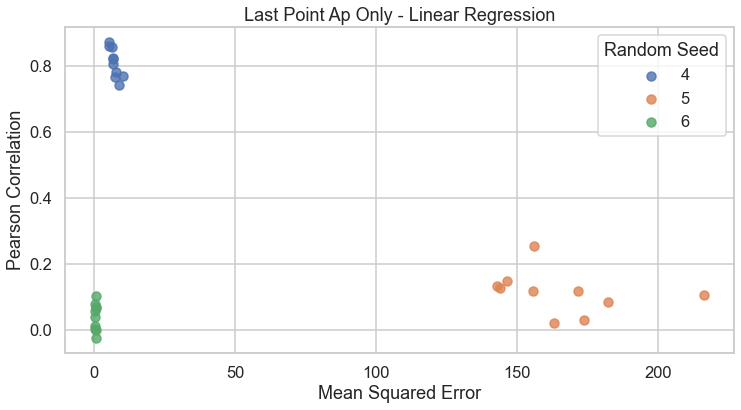

In [36]:
# correlation between the mean squared error and the pearson correlation using matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_palette("deep")
plt.figure(figsize=(12, 6))

seeds = ['4', '5', '6']
for i, metric_df in enumerate(metric_dfs):
    # filter the dataframe for the rows where the column 'Feature Data' is 'Mock Omics Data (A+B)'
    filtered_df = metric_df[metric_df['Feature Data'] == 'Last Point Ap Only']
    # filter the dataframe for the rows where the column 'Model' is 'Linear Regression'
    filtered_df = filtered_df[filtered_df['Model'] == 'Linear Regression']
    # calculate the mean of the pearson correlation for all rows
    mse = filtered_df['Mean Squared Error']
    pearson = filtered_df['Pearson Correlation']

    plt.scatter(mse, pearson, label=seeds[i], alpha=0.8)
plt.xlabel('Mean Squared Error')
plt.ylabel('Pearson Correlation')   
plt.title('Last Point Ap Only - Linear Regression')
plt.legend(title='Random Seed')
plt.show()

In [51]:
# perform a multiple t-test for the pearson correlation of the filtered dataframe and adjust the p-values using the Bonferroni correction
from scipy.stats import ttest_rel

def plot_specific_data_types(metric_df, data_types, model, ylimit=(0, 1), no_legend=False, no_title=False, eval_column='Pearson Correlation'):
    # filter the dataframe for the rows where the column 'Feature Data' is in the data_types
    filtered_df = metric_df[metric_df['Feature Data'].isin(data_types)]
    # filter the dataframe for the rows where the column 'Model' is in the model
    filtered_df = filtered_df[filtered_df['Model'] == model]
    plt.figure(figsize=(3, 5))
    sns.set(font_scale=1.8)
    sns.set_style("whitegrid")
    sns.stripplot(data=filtered_df, x='Model', y=eval_column,
                hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)
    sns.boxplot(data=filtered_df, x='Model',
                y=eval_column, hue='Feature Data')
    for patch in plt.gca().patches:
        patch.set_alpha(0.3)
    plt.title(f'Model Performance Comparison for {eval_column}')
    if no_title:
        plt.title('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if no_legend:
        plt.legend().remove()
    ylim_min, ylim_max = ylimit
    plt.ylim(ylim_min, ylim_max)
    plt.show()
    
    return filtered_df

def get_data_pivot(metric_df, data_types, model, eval_column='Pearson Correlation'):
    # filter the dataframe for the rows where the column 'Feature Data' is in the data_types
    filtered_df = metric_df[metric_df['Feature Data'].isin(data_types)]
    # filter the dataframe for the rows where the column 'Model' is in the model
    filtered_df = filtered_df[filtered_df['Model'] == model]
    data = filtered_df.groupby(['Feature Data', 'Model'])[eval_column].mean().reset_index()
    # pivot the dataframe to get the mean pearson correlation for each feature data type
    data_pivot = data.pivot(index='Feature Data', columns='Model', values=eval_column)
    return data_pivot   


def multiple_t_test(metric_df, data_types, model, eval_column='Pearson Correlation'): 
    # apply on the filtered dataframe
    filtered_df = metric_df[metric_df['Model'] == model]
    filtered_df = filtered_df[filtered_df['Feature Data'].isin(data_types)]
    # get the pearson correlation for each feature data type
    extracted_column = filtered_df.groupby(['Feature Data', 'Model'])[eval_column].apply(list).reset_index()
    # perform a t-test for each pair of feature data types
    t_test_results = []
    for i in range(len(extracted_column)):
        for j in range(i+1, len(extracted_column)):
            # perform a t-test for each pair of feature data types
            t_stat, p_value = ttest_rel(extracted_column[eval_column][i], extracted_column[eval_column][j])
            # append the results to the list
            t_test_results.append((extracted_column['Feature Data'][i], extracted_column['Feature Data'][j], t_stat, p_value))
    # create a dataframe from the t-test results
    t_test_df = pd.DataFrame(t_test_results, columns=['Data Type 1', 'Data Type 2', 't-statistic', 'p-value'])
    # adjust the p-values using the Bonferroni correction
    t_test_df['Bonferroni p-value'] = t_test_df['p-value'] * len(t_test_df)
    # print the t-test results
    return t_test_df

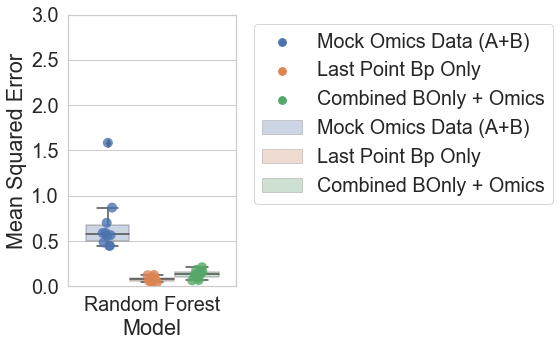

In [63]:
feature_sets_compared = ['Mock Omics Data (A+B)', 'Last Point Bp Only', 'Combined BOnly + Omics']
model = 'Random Forest'
eval_column = 'Mean Squared Error'

filtered_df = plot_specific_data_types(metric_df1, feature_sets_compared, model, eval_column=eval_column, ylimit=(0, 3), no_title=True)

In [64]:
pivot_result = get_data_pivot(metric_df1, feature_sets_compared, model, eval_column=eval_column)
print(pivot_result)

Model                   Random Forest
Feature Data                         
Combined BOnly + Omics       0.133054
Last Point Bp Only           0.080023
Mock Omics Data (A+B)        0.683131


In [65]:
multiple_t_test_results = multiple_t_test(metric_df1, feature_sets_compared, model, eval_column=eval_column)
multiple_t_test_results

,Data Type 1,Data Type 2,t-statistic,p-value,Bonferroni p-value
0,Combined BOnly + Omics,Last Point Bp Only,4.381730,0.001767,0.005300
1,Combined BOnly + Omics,Mock Omics Data (A+B),-5.107725,0.000638,0.001915
2,Last Point Bp Only,Mock Omics Data (A+B),-5.559645,0.000352,0.001056


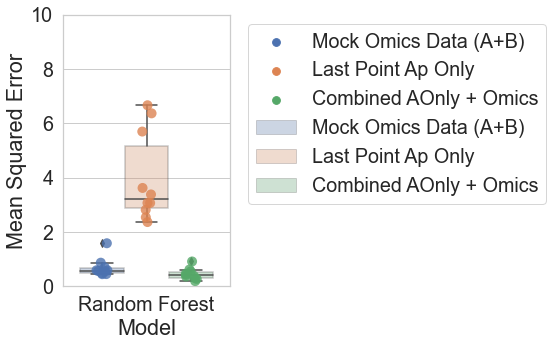

In [69]:
feature_sets_compared = ['Mock Omics Data (A+B)', 'Last Point Ap Only', 'Combined AOnly + Omics']
model = 'Random Forest'
eval_column = 'Mean Squared Error'

filtered_df = plot_specific_data_types(metric_df1, feature_sets_compared, model, eval_column=eval_column, ylimit=(0, 10), no_title=True)

In [67]:
pivot_result = get_data_pivot(metric_df1, feature_sets_compared, model, eval_column=eval_column)
print(pivot_result)

Model                   Random Forest
Feature Data                         
Combined AOnly + Omics       0.445694
Last Point Ap Only           3.956620
Mock Omics Data (A+B)        0.683131


In [68]:
multiple_t_test_results = multiple_t_test(metric_df1, feature_sets_compared, model, eval_column=eval_column)
multiple_t_test_results

,Data Type 1,Data Type 2,t-statistic,p-value,Bonferroni p-value
0,Combined AOnly + Omics,Last Point Ap Only,-7.065196,0.000059,0.000177
1,Combined AOnly + Omics,Mock Omics Data (A+B),-1.826005,0.101135,0.303405
2,Last Point Ap Only,Mock Omics Data (A+B),5.885688,0.000233,0.000700


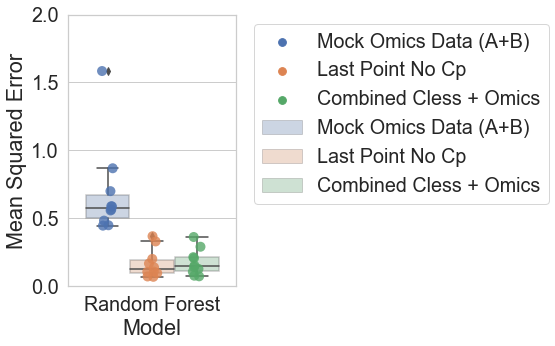

In [80]:
feature_sets_compared = ['Combined Cless + Omics', 'Mock Omics Data (A+B)', 'Last Point No Cp']
model = 'Random Forest'
eval_column = 'Mean Squared Error'

filtered_df = plot_specific_data_types(metric_df1, feature_sets_compared, model, eval_column=eval_column, ylimit=(0, 2), no_title=True)

In [81]:
pivot_result = get_data_pivot(metric_df1, feature_sets_compared, model, eval_column=eval_column)
print(pivot_result)

Model                   Random Forest
Feature Data                         
Combined Cless + Omics       0.175655
Last Point No Cp             0.166152
Mock Omics Data (A+B)        0.683131


In [82]:
multiple_t_test_results = multiple_t_test(metric_df1, feature_sets_compared, model, eval_column=eval_column)
multiple_t_test_results

,Data Type 1,Data Type 2,t-statistic,p-value,Bonferroni p-value
0,Combined Cless + Omics,Last Point No Cp,1.290756,0.228958,0.686874
1,Combined Cless + Omics,Mock Omics Data (A+B),-4.365388,0.001809,0.005428
2,Last Point No Cp,Mock Omics Data (A+B),-4.330282,0.001904,0.005713
